# Analysis Pipeline

Given any segment of time-series data:
- Compute spectrogram (with window length and step length parameters)
- Fit exponential distribution over all frequencies and compute KS test value & p-value
- Compute SCV over same period (maybe throw out 1% outliers?)
- Compute the PSD from that time period (compute the spectrogram mean over time bins)
- Fooof PSD in 3 differe ways (take care to ignore 60Hz power line), and for each, save the fitted slope, offset, and fit error:

     1. Fit straight line over all frequencies (2-80Hz)

     2. Fit lorentzian over all frequencies (2-80Hz)

     3. Fit straight line over only the frequency ranges that are not significant under KS test

In [1]:
cd ..

C:\Users\Lauren\Voytek\spectralCV


In [15]:
# imports
from scv_funcs import access_nt as asc
import numpy as np
import neurodsp as ndsp
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import expon
import scipy as sp

In [31]:
# object that has attributes for taking any segment/ time-series data
class lfpca:
    
    # segment also include attributes of fs, nperseg, and noverlap
    def __init__(self,data,fs,nperseg,noverlap=0):
        self.data = data
        self.fs = fs
        self.nperseg = nperseg
        self.noverlap = noverlap
                
    # calculate the psd
    def psd(self):
        f, psd_ = ndsp.spectral.psd(data, Fs=fs, nperseg=nperseg, noverlap=noverlap)
        return f, psd_
    
    # plotting histogram for a specific channel and frequency and fitting an exp pdf over it
    def plot_expfit(self,chan,freq_ind,num_bins=100):
        fig, ax = plt.subplots(1, 1)
        f_axis_, t_axis_, spg_ = sp.signal.spectrogram(data[chan-1],fs=fs,nperseg=nperseg,noverlap=noverlap)
        _, scale_ = sp.stats.expon.fit(spg_[freq_ind],floc=0)
        hists = ax.hist(spg_[freq_ind],normed=True,bins=num_bins)
        x = hists[1]
        rv = expon(scale = scale_)
        ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf',)
        plt.legend()
        plt.title('Frequency=%.1f Hz' %f[freq_ind])
        plt.show()
    
    # calculate spectrogram of a specific channel and fitting against exponential
    # calculating against ks test to get the test statistics and p-values
    def ks_expfit(self,chan):
        f_axis_, t_axis_, spg_ = sp.signal.spectrogram(data[chan-1],fs=fs,nperseg=nperseg,noverlap=noverlap)
        pvals = np.zeros((len(spg_)))
        statistics = np.zeros((len(spg_)))
        for i in range(len(spg_)):
            param = sp.stats.expon.fit(spg_[i], floc=0)
            stat, pval = sp.stats.kstest(spg_[i], 'expon', args=param)
            pvals[i] = pval
            statistics[i] = stat
        return pvals, statistics
    
    # calcuating the scv of a specific channel
    def scv(self,chan):
        f, scv_ = ndsp.spectral.scv(data[chan-1], Fs=fs, nperseg=nperseg, noverlap=noverlap, outlierpct=1)
        return f, scv_
    
   # def 

In [10]:
data_path ="/Users/Lauren/Data/NeuroTycho/anesthesia/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
#data_path ="/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
session = 1
chan = [1,2,3,4] # start at 1

# with specified indices
indices = [0,0]
data = asc.get_ECoG(data_path, session, chan, indices)

In [11]:
# example of using seg_fit
fs = 1000
nperseg = 1000
noverlap = 0

lfpca = lfpca(data,fs,nperseg,noverlap)

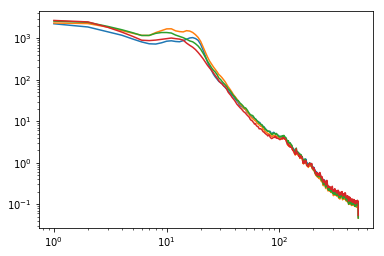

In [13]:
# example of psd
f, psd_ = lfpca.psd()
plt.loglog(f,psd_[0:,:].T);

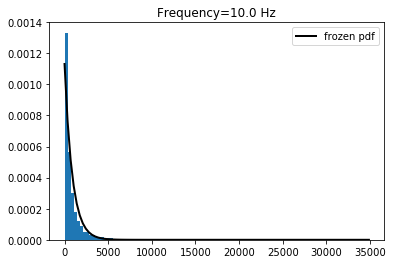

In [37]:
# example of plotting fitting exponential over specific frequency
lfpca.plot_expfit(self=lfpca,chan=1,freq_ind=10,num_bins=100)